In [1]:
import numpy as np
import matplotlib as mpl

import lightkurve as lk
import tessbkgd


In [2]:
%pylab inline --no-import-all
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
mpl.rcParams['font.size']=22              #10 
mpl.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

Populating the interactive namespace from numpy and matplotlib


In [3]:
target = "iot Dra"

In [4]:
search = lk.search_targetpixelfile(target)

In [5]:
search

SearchResult containing 5 data products.

 #   observation   target_name                     productFilename                     distance
--- -------------- ----------- ------------------------------------------------------- --------
  0 TESS Sector 15   165722603 tess2019226182529-s0015-0000000165722603-0151-s_tp.fits      0.0
  1 TESS Sector 16   165722603 tess2019253231442-s0016-0000000165722603-0152-s_tp.fits      0.0
  2 TESS Sector 22   165722603 tess2020049080258-s0022-0000000165722603-0174-s_tp.fits      0.0
  3 TESS Sector 23   165722603 tess2020078014623-s0023-0000000165722603-0177-s_tp.fits      0.0
  4 TESS Sector 24   165722603 tess2020106103520-s0024-0000000165722603-0180-s_tp.fits      0.0

In [6]:
tpf = search[0].download()

In [7]:
tpf.__class__ = tessbkgd.tessbkgd.bkgd_tpf

In [8]:
newbkgd = tpf.get_bkgd()

/home/tim/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/tim/anaconda3/lib/python3.7/site-packages/tessbkgd-0.1-py3.7.egg/tessbkgd/tessbkgd.py:34: RuntimeWarning: invalid value encountered in greater
/home/tim/anaconda3/lib/python3.7/site-packages/tessbkgd-0.1-py3.7.egg/tessbkgd/tessbkgd.py:35: RuntimeWarning: invalid value encountered in less


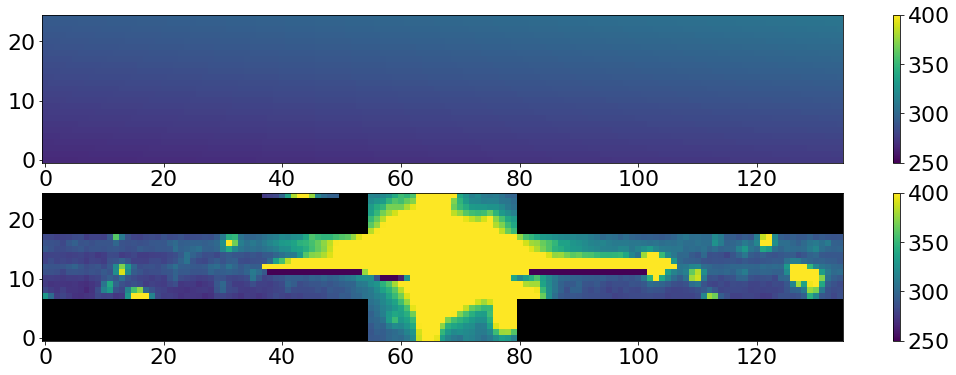

In [9]:
fig,axes = plt.subplots(2,1,figsize=(18,6))

xl=-0.5,134.5
asp = 1
frame = 8250
cmax = 400
cmin = 250

cmap = mpl.cm.viridis
cmap.set_bad('k',1.)
im = ((newbkgd[frame,:,:]).T)
img = axes[0].imshow(im,cmap=cmap, vmin=np.nanmin(cmin),vmax=np.nanmax(cmax),
    interpolation='None',origin='lower',aspect=asp)
plt.colorbar(img, ax=axes[0])

im2 = (((tpf.flux[frame,:,:]+tpf.flux_bkg[frame,:,:])).T)
img = axes[1].imshow(im2,cmap=cmap, vmin=np.nanmin(cmin),vmax=np.nanmax(cmax),
    interpolation='None',origin='lower',aspect=asp)
plt.colorbar(img, ax=axes[1])

plt.show()

In [10]:
tpf.flux = tpf.flux + tpf.flux_bkg - newbkgd
tpf.flux_bkg = newbkgd

In [11]:
from scipy.ndimage.morphology import binary_dilation

In [12]:
sapmask = tpf.create_threshold_mask(threshold=50)
sapmask = binary_dilation(sapmask)
sapmask = binary_dilation(sapmask)

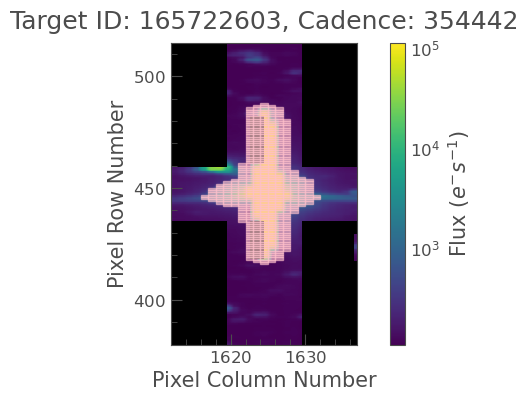

In [13]:
tpf.plot(aspect=0.3, scale='log', bkg = True, frame = 6000, aperture_mask = sapmask)
plt.show()

In [14]:
lc = tpf.extract_aperture_photometry(aperture_mask=sapmask)

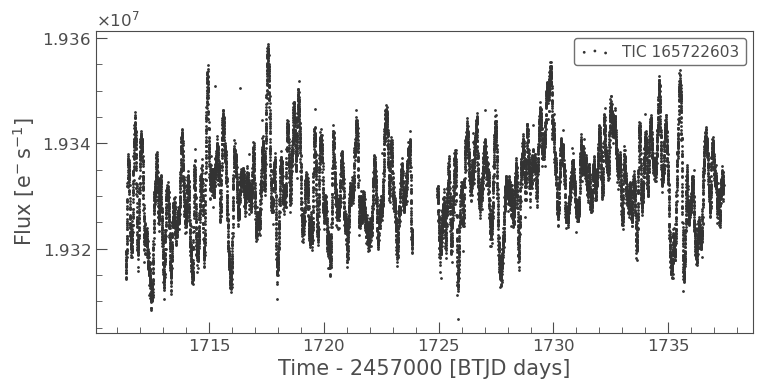

In [15]:
lc.scatter();

In [16]:
tpf.to_fits(output_fn='iotDra_Sector15.fits')

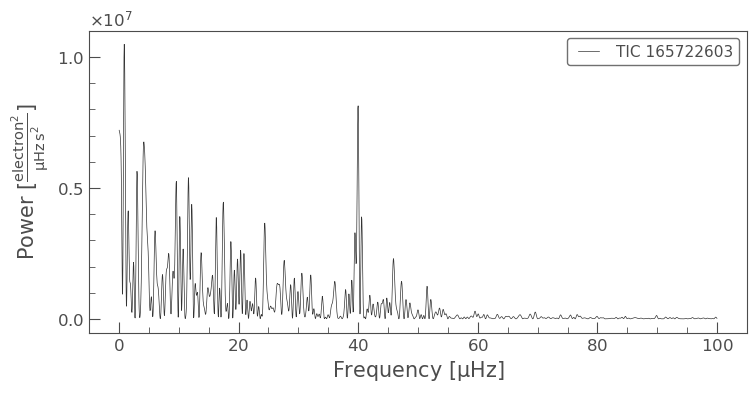

In [17]:
pg = lc.remove_nans().remove_outliers().to_periodogram(normalization='psd', oversample_factor=10, maximum_frequency = 100)
pg.plot();